Import necessary libraries

In [1]:
import bisect

import pandas as pd
import numpy as np
from sklearn import preprocessing 
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split

import keras
import tensorflow as tf
from keras.models import Sequential
from keras.layers import Dense
from keras import initializers
from keras.models import load_model

import seaborn as sns

2023-10-06 19:09:56.750899: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


Load data, drop columns that are not needed/wanted

In [26]:
#load data
df = pd.read_csv('/Users/nic/desktop/ML-Vapor-Pressures/models/model_data.csv')

df.drop(["Unnamed: 0"], axis=1, inplace = True)

df['X'] = df['N_H+(mol)'] / (df['N_H+(mol)'] + df['N_NH4+(mol)'] + df['N_Na+(mol)'])
df['Y'] = df['N_NH4+(mol)'] / (df['N_H+(mol)'] + df['N_NH4+(mol)'] + df['N_Na+(mol)'])
df['W'] = df['N_Cl-(mol)'] / (df['N_Cl-(mol)'] + df['N_NO3-(mol)'] + df['N_SO42-(mol)'])
df['P'] = df['N_NO3-(mol)'] / (df['N_Cl-(mol)'] + df['N_NO3-(mol)'] + df['N_SO42-(mol)'])

#check for NA instances
print("# of na rows per column")
print(df.isna().sum())

#check for duplicates
print("# of duplicates")
print(df.duplicated().sum())
#df.drop_duplicates(inplace=True)
df

# of na rows per column
Temp(K)               0
RH                    0
N_H+(mol)             0
N_NH4+(mol)           0
N_Na+(mol)            0
N_SO42-(mol)          0
N_NO3-(mol)           0
N_Cl-(mol)            0
N_OH-(mol)            0
N_NH3-(mol)           0
Water Content(mol)    0
P_HNO3(atm)           0
P_HCL(atm)            0
P_NH3(atm)            0
P_H2SO4(atm)          0
P_HBr(atm)            0
contains_solid        0
X                     0
Y                     0
W                     0
P                     0
dtype: int64
# of duplicates
0


,Temp(K),RH,N_H+(mol),N_NH4+(mol),N_Na+(mol),N_SO42-(mol),N_NO3-(mol),N_Cl-(mol),N_OH-(mol),N_NH3-(mol),...,P_HNO3(atm),P_HCL(atm),P_NH3(atm),P_H2SO4(atm),P_HBr(atm),contains_solid,X,Y,W,P
0,298.15,0.85,0.0,8.000000e-08,2.000000e-08,1.380000e-08,2.500000e-08,4.750000e-08,0.0,0.0,...,2.666810e-12,1.341610e-11,0.000001,3.171190e-29,0.0,0,0.0,0.8,0.550406,0.289687
1,298.15,0.80,0.0,8.000000e-08,2.000000e-08,1.380000e-08,2.500000e-08,4.750000e-08,0.0,0.0,...,3.498020e-12,2.155460e-11,0.000001,4.547500e-29,0.0,0,0.0,0.8,0.550406,0.289687
2,298.15,0.70,0.0,8.000000e-08,2.000000e-08,1.380000e-08,2.500000e-08,4.750000e-08,0.0,0.0,...,4.767620e-12,4.293270e-11,0.000002,7.690580e-29,0.0,0,0.0,0.8,0.550406,0.289687
3,298.15,0.65,0.0,8.000000e-08,2.000000e-08,1.380000e-08,2.500000e-08,4.750000e-08,0.0,0.0,...,5.323350e-12,3.944190e-11,0.000002,7.991640e-29,0.0,1,0.0,0.8,0.550406,0.289687
4,298.15,0.60,0.0,8.000000e-08,2.000000e-08,1.380000e-08,2.500000e-08,4.750000e-08,0.0,0.0,...,9.399680e-12,3.872550e-11,0.000002,8.371850e-29,0.0,1,0.0,0.8,0.550406,0.289687
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
24495,298.15,0.55,0.0,3.099364e-08,7.748410e-09,1.937102e-09,1.355972e-08,2.130813e-08,0.0,0.0,...,1.436290e-11,4.820140e-11,0.000002,8.480730e-29,0.0,1,0.0,0.8,0.578947,0.368421
24496,298.15,0.50,0.0,3.099364e-08,7.748410e-09,1.937102e-09,1.355972e-08,2.130813e-08,0.0,0.0,...,1.807320e-11,4.453900e-11,0.000002,9.091330e-29,0.0,1,0.0,0.8,0.578947,0.368421
24497,298.15,0.45,0.0,3.099364e-08,7.748410e-09,1.937102e-09,1.355972e-08,2.130813e-08,0.0,0.0,...,2.165810e-11,4.228600e-11,0.000002,9.682810e-29,0.0,1,0.0,0.8,0.578947,0.368421
24498,298.15,0.35,0.0,3.099364e-08,7.748410e-09,1.937102e-09,1.355972e-08,2.130813e-08,0.0,0.0,...,0.000000e+00,0.000000e+00,0.000000,0.000000e+00,0.0,1,0.0,0.8,0.578947,0.368421


Liquid

In [3]:
#only want rows of liquid
df = df.drop(df[df['contains_solid'] == 1].index)

#drop all rows where NH4+, NO3- are 0 (partial pressure product will be 0)
df = df.drop(df[df['N_NH4+(mol)'] == 0].index)
df = df.drop(df[df['N_Cl-(mol)'] == 0].index)

Liquid / Solid

In [27]:
#must contain solid
df = df.drop(df[(df['contains_solid'] == 0) | (df['Water Content(mol)'] == 0)].index)

#drop all rows where NH4+, NO3- are 0 (partial pressure product will be 0)
df = df.drop(df[df['N_NH4+(mol)'] == 0].index)
df = df.drop(df[df['N_Cl-(mol)'] == 0].index)

,Temp(K),RH,N_H+(mol),N_NH4+(mol),N_Na+(mol),N_SO42-(mol),N_NO3-(mol),N_Cl-(mol),N_OH-(mol),N_NH3-(mol),...,P_HNO3(atm),P_HCL(atm),P_NH3(atm),P_H2SO4(atm),P_HBr(atm),contains_solid,X,Y,W,P
3,298.15,0.65,0.0,8.000000e-08,2.000000e-08,1.380000e-08,2.500000e-08,4.750000e-08,0.0,0.0,...,5.323350e-12,3.944190e-11,0.000002,7.991640e-29,0.0,1,0.0,0.8,0.550406,0.289687
4,298.15,0.60,0.0,8.000000e-08,2.000000e-08,1.380000e-08,2.500000e-08,4.750000e-08,0.0,0.0,...,9.399680e-12,3.872550e-11,0.000002,8.371850e-29,0.0,1,0.0,0.8,0.550406,0.289687
5,298.15,0.55,0.0,8.000000e-08,2.000000e-08,1.380000e-08,2.500000e-08,4.750000e-08,0.0,0.0,...,1.282580e-11,3.776860e-11,0.000002,8.716390e-29,0.0,1,0.0,0.8,0.550406,0.289687
6,298.15,0.50,0.0,8.000000e-08,2.000000e-08,1.380000e-08,2.500000e-08,4.750000e-08,0.0,0.0,...,1.566020e-11,3.661730e-11,0.000002,9.029060e-29,0.0,1,0.0,0.8,0.550406,0.289687
13,298.15,0.65,0.0,7.200000e-08,1.800000e-08,1.242000e-08,2.250000e-08,4.275000e-08,0.0,0.0,...,5.323350e-12,3.944190e-11,0.000002,7.991640e-29,0.0,1,0.0,0.8,0.550406,0.289687
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
24493,298.15,0.65,0.0,3.099364e-08,7.748410e-09,1.937102e-09,1.355972e-08,2.130813e-08,0.0,0.0,...,1.159650e-11,6.964250e-11,0.000001,8.692590e-29,0.0,1,0.0,0.8,0.578947,0.368421
24494,298.15,0.60,0.0,3.099364e-08,7.748410e-09,1.937102e-09,1.355972e-08,2.130813e-08,0.0,0.0,...,1.206400e-11,5.428650e-11,0.000001,8.418160e-29,0.0,1,0.0,0.8,0.578947,0.368421
24495,298.15,0.55,0.0,3.099364e-08,7.748410e-09,1.937102e-09,1.355972e-08,2.130813e-08,0.0,0.0,...,1.436290e-11,4.820140e-11,0.000002,8.480730e-29,0.0,1,0.0,0.8,0.578947,0.368421
24496,298.15,0.50,0.0,3.099364e-08,7.748410e-09,1.937102e-09,1.355972e-08,2.130813e-08,0.0,0.0,...,1.807320e-11,4.453900e-11,0.000002,9.091330e-29,0.0,1,0.0,0.8,0.578947,0.368421


Identify the target (ammonium chloride partial pressure product) and calculate its value

In [28]:
target = pd.Series( df['P_HCL(atm)'] * df['P_NH3(atm)'] )

Standardize data

In [29]:
scalers = {}
for col in df.columns:
    mean = df[col].mean()
    std = df[col].std(ddof=0)
    df[col] = (df[col] - mean) / std
    scalers[col] = (mean, std)

#Standardize ammonium chloride
amm_chl_mean = target.mean()
amm_chl_std = target.std(ddof=0)
target = (target - amm_chl_mean) / amm_chl_std

df.describe()

,Temp(K),RH,N_H+(mol),N_NH4+(mol),N_Na+(mol),N_SO42-(mol),N_NO3-(mol),N_Cl-(mol),N_OH-(mol),N_NH3-(mol),...,P_HNO3(atm),P_HCL(atm),P_NH3(atm),P_H2SO4(atm),P_HBr(atm),contains_solid,X,Y,W,P
count,0.0,1.116000e+04,0.0,1.116000e+04,1.116000e+04,1.116000e+04,1.116000e+04,1.116000e+04,0.0,0.0,...,1.116000e+04,1.116000e+04,1.116000e+04,1.116000e+04,0.0,0.0,0.0,1.116000e+04,1.116000e+04,1.116000e+04
mean,NaN,-3.947460e-16,NaN,2.037399e-17,-3.871057e-16,2.037399e-17,2.546748e-16,2.164736e-16,NaN,NaN,...,-1.528049e-17,-1.477114e-16,-2.444878e-16,1.884594e-16,NaN,NaN,NaN,1.731789e-15,8.455204e-16,-4.686017e-16
std,NaN,1.000045e+00,NaN,1.000045e+00,1.000045e+00,1.000045e+00,1.000045e+00,1.000045e+00,NaN,NaN,...,1.000045e+00,1.000045e+00,1.000045e+00,1.000045e+00,NaN,NaN,NaN,1.000045e+00,1.000045e+00,1.000045e+00
min,NaN,-1.601085e+00,NaN,-1.549483e+00,-1.548034e+00,-1.646581e+00,-1.516674e+00,-1.555912e+00,NaN,NaN,...,-1.002541e+00,-7.485179e-01,-2.881022e+00,-5.819565e+00,NaN,NaN,NaN,-1.455789e+00,-2.043441e+00,-1.683066e+00
25%,NaN,-8.693850e-01,NaN,-8.443887e-01,-7.755270e-01,-7.561823e-01,-8.037494e-01,-8.456189e-01,NaN,NaN,...,-4.546013e-01,-4.032838e-01,-6.650080e-01,-2.875849e-01,NaN,NaN,NaN,-7.438433e-01,-6.982716e-01,-9.615753e-01
50%,NaN,-1.376854e-01,NaN,-1.376643e-01,-1.852725e-01,-1.386827e-01,-1.795259e-01,-1.336842e-01,NaN,NaN,...,-1.882820e-01,-2.485120e-01,8.418276e-02,1.171651e-01,NaN,NaN,NaN,-3.189723e-02,-3.754982e-03,5.285137e-02
75%,NaN,5.940142e-01,NaN,7.551082e-01,6.521974e-01,6.152667e-01,6.333194e-01,7.656703e-01,NaN,NaN,...,3.367831e-01,7.635880e-02,6.131394e-01,5.417987e-01,NaN,NaN,NaN,6.800489e-01,7.237642e-01,9.071054e-01
max,NaN,2.057413e+00,NaN,2.360170e+00,2.739226e+00,3.524539e+00,2.799346e+00,2.382566e+00,NaN,NaN,...,1.017256e+01,7.564491e+00,2.700354e+00,1.107813e+00,NaN,NaN,NaN,1.391995e+00,2.229449e+00,1.568260e+00


Histogram of Ammonium Chloride

<AxesSubplot: >

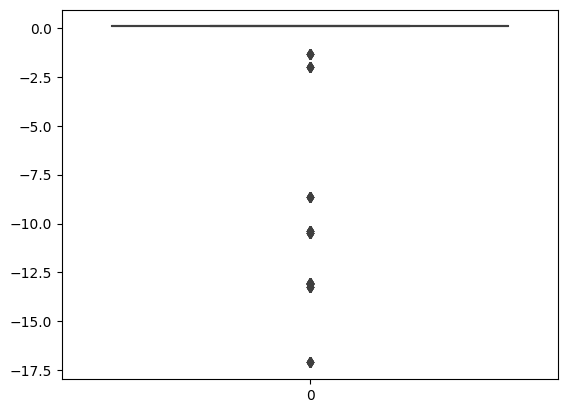

In [30]:
# Box Plot
sns.boxplot(target.values)

Split data into train/test/val

In [31]:
X = df[['RH', 'Y', 'W', 'P']]

X_train, X_test, y_train, y_test = train_test_split(X, target, test_size = 0.2, shuffle=True)

#split for val
X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=0.25)

TWO OPTIONS FOR MODEL:
    1. Load previously trained model
    2. Train new model

Load model

In [6]:
model_amm_chl = load_model('h5/amm_chl.h5')
model_amm_chl.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense (Dense)               (None, 16)                80        
                                                                 
 dense_1 (Dense)             (None, 16)                272       
                                                                 
 dense_2 (Dense)             (None, 1)                 17        
                                                                 
Total params: 369
Trainable params: 369
Non-trainable params: 0
_________________________________________________________________


2023-09-26 09:15:08.977340: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


Train model

In [32]:
model_amm_chl = Sequential()
#model_water_content.add(Dense(input_dim = 9, units=8, activation=keras.layers.LeakyReLU(alpha=0.3), bias_initializer = initializers.RandomUniform(minval=-0.3, maxval=0.3, seed=None)))
model_amm_chl.add(Dense(input_dim = 4, units=16, activation='tanh'))
model_amm_chl.add(Dense(units=16, activation='tanh'))
model_amm_chl.add(Dense(units=1))

optimizer = keras.optimizers.Adam(learning_rate=0.001)
model_amm_chl.compile(optimizer = optimizer, loss = 'MeanSquaredError', metrics=['MeanSquaredError'])
history = model_amm_chl.fit(X_train, y_train, validation_data=(X_test, y_test), batch_size=32, epochs=500, shuffle=True)

Epoch 1/500
210/210 [==============================] - 1s 3ms/step - loss: 1.1284 - mean_squared_error: 1.1284 - val_loss: 1.0184 - val_mean_squared_error: 1.0184
Epoch 2/500
210/210 [==============================] - 1s 3ms/step - loss: 1.0247 - mean_squared_error: 1.0247 - val_loss: 0.9942 - val_mean_squared_error: 0.9942
Epoch 3/500
210/210 [==============================] - 0s 2ms/step - loss: 1.0076 - mean_squared_error: 1.0076 - val_loss: 0.9713 - val_mean_squared_error: 0.9713
Epoch 4/500
210/210 [==============================] - 0s 2ms/step - loss: 0.9774 - mean_squared_error: 0.9774 - val_loss: 0.9428 - val_mean_squared_error: 0.9428
Epoch 5/500
210/210 [==============================] - 0s 2ms/step - loss: 0.9444 - mean_squared_error: 0.9444 - val_loss: 0.9051 - val_mean_squared_error: 0.9051
Epoch 6/500
210/210 [==============================] - 0s 2ms/step - loss: 0.9079 - mean_squared_error: 0.9079 - val_loss: 0.8672 - val_mean_squared_error: 0.8672
Epoch 7/500
210/210 [=

Save model

In [23]:
model_amm_chl.save('h5/amm_chl.h5')

Loss graph

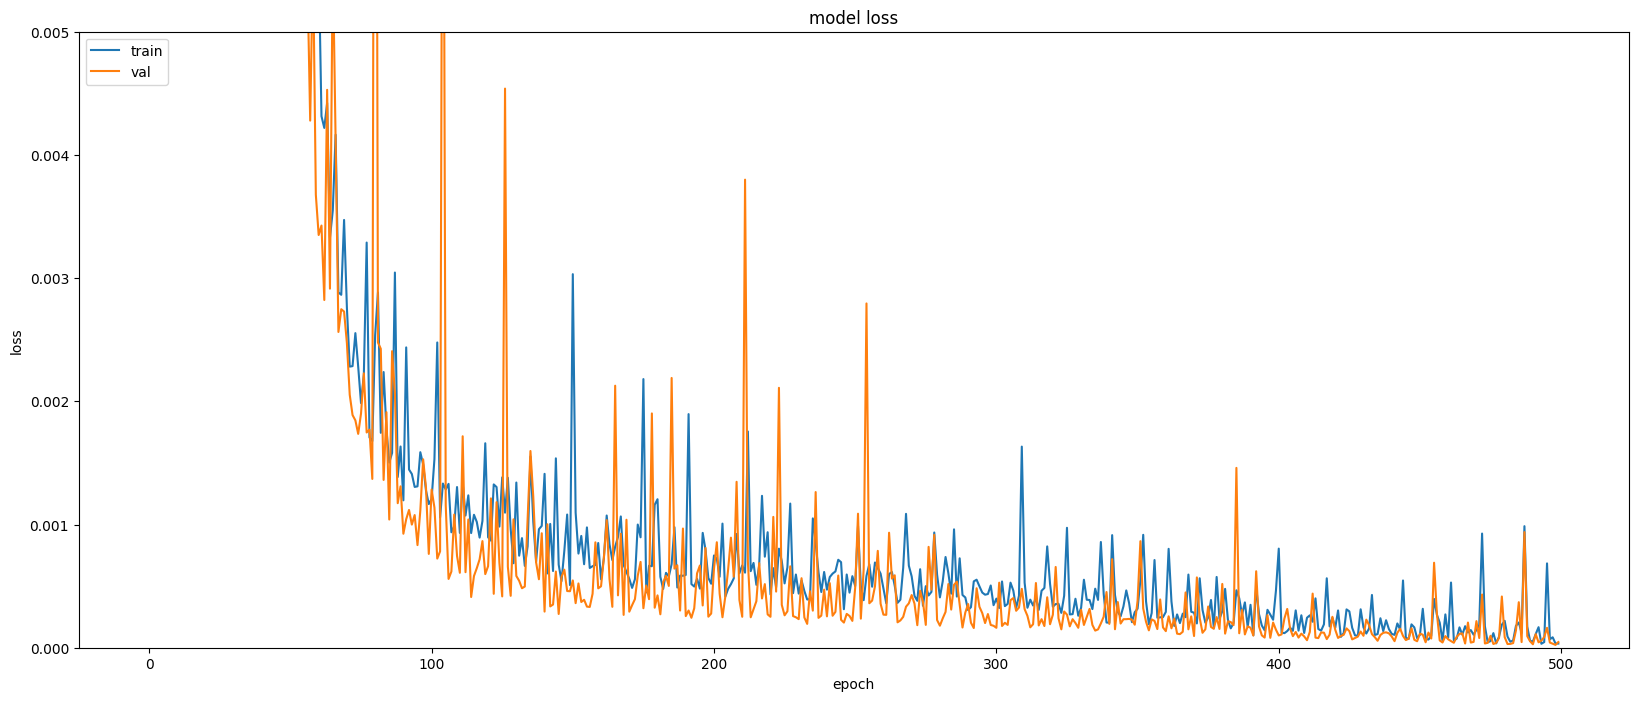

In [33]:
plt.figure(figsize=(20,8))
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
axis = plt.gca()
axis.set_ylim([0, 0.005])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.show()

Generate predictions from model

In [34]:
y_pred = model_amm_chl.predict(X_test)

70/70 [==============================] - 0s 1ms/step


Accuracy graph 

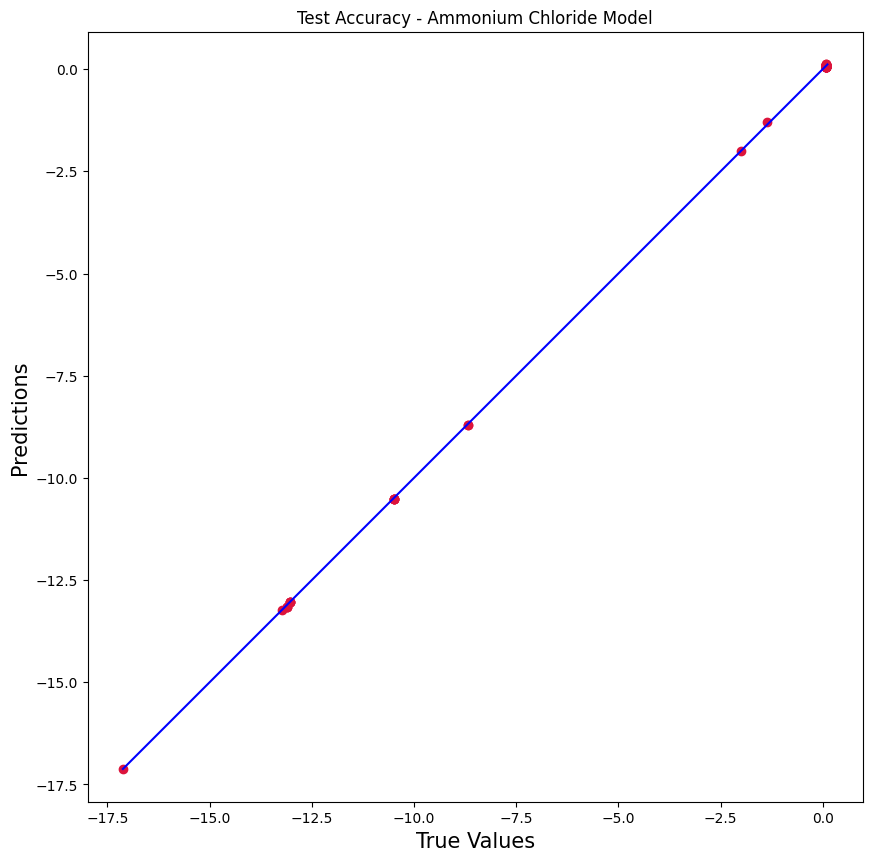

In [35]:
plt.figure(figsize=(10,10))
plt.scatter(y_test, y_pred, c='crimson')
#plt.yscale('log')
#plt.xscale('log')
p1 = max(max(y_pred), max(y_test))
p2 = min(min(y_pred), min(y_test))
plt.plot([p1, p2], [p1, p2], 'b-')
plt.title('Test Accuracy - Ammonium Chloride Model')
plt.xlabel('True Values', fontsize=15)
plt.ylabel('Predictions', fontsize=15)
plt.axis('equal')
plt.show()

Destandardize data

In [36]:
y_test_destan = y_test * amm_chl_std + amm_chl_mean
y_pred_destan = y_pred * amm_chl_std + amm_chl_mean 

#change negative values from destandardization to 0
y_test[y_test < 0] = 0
y_pred[y_pred < 0] = 0

#destandardize features
for col in X_test.columns:
    X_test[col] = X_test[col] * scalers[col][1] + scalers[col][0]

X_test.describe()

,RH,Y,W,P
count,2232.000000,2232.000000,2232.000000,2232.000000
mean,0.559745,0.701501,0.593424,0.279795
std,0.069077,0.070433,0.051279,0.096423
min,0.450000,0.600000,0.486486,0.117647
25%,0.500000,0.650000,0.555556,0.187500
50%,0.550000,0.700000,0.591216,0.281532
75%,0.600000,0.750000,0.630137,0.363636
max,0.700000,0.800000,0.705882,0.432432


Calculate numerical model accuracy metrics (Normalized Mean Absolute Error (NMAE) & Normalized Mean Bias Error (NMBE))

In [37]:
nmae = 0
nmbe = 0
num_elements = 0

largest_thirty_errors = [0] * 30

for ea, nn in zip(y_test_destan, y_pred_destan):
    num_elements += 1

    nn = nn[0]

    if ea == 0 and nn == 0: 
        print("here")
        continue

    if 2 * abs(ea - nn) / (ea + nn) > largest_thirty_errors[0]:
        '''
        index = 0
        for err in largest_thirty_errors:
            if abs(ea-nn) > err:
                if index != 29:
                    index += 1
            else:
                index -= 1
                break

        nn_vals_largest_error.pop(0)
        nn_vals_largest_error.insert(index, nn)
        '''

        largest_thirty_errors.pop(0)

        bisect.insort(largest_thirty_errors, 2 * abs(ea - nn) / (ea + nn))

    nmae += 2 * abs(ea-nn) / (ea+nn) 
    nmbe += 2 * (nn - ea) / (nn + ea)

nmae /= num_elements
nmbe /= num_elements

print(largest_thirty_errors)
print("Normalized Mean Absolute Error:")
print(nmae)
print("Normalized Mean Bias Error:")
print(nmbe)

[0.00036421990076135693, 0.00036421990076135693, 0.00036421990076135693, 0.00038004582334830183, 0.00038004582334830183, 0.00038004582334830183, 0.00038004582334830183, 0.00039352665801207706, 0.00040530395605168154, 0.00040530395605168154, 0.00040530395605168154, 0.0004225668665275866, 0.0004225668665275866, 0.0004225668665275866, 0.00046599225435758077, 0.00046599225435758077, 0.0004784802927713835, 0.0004784802927713835, 0.00048722032418023784, 0.0005045496463823593, 0.0005045496463823593, 0.0005045496463823593, 0.0006220603931196657, 0.0006220603931196657, 0.0006260210802133619, 0.0006260210802133619, 0.0007848557964586312, 0.0007849642426383811, 0.0007849642426383811, 0.0008620712080320274]
Normalized Mean Absolute Error:
0.00010213561088225802
Normalized Mean Bias Error:
-9.076764002552621e-05
